In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import skimage
from skimage import io
import pickle
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

np.random.seed(666)
torch.manual_seed(666);

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Colab Notebooks/data_DL_project")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to add pictures to google drive?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Data loading and preprocessing

In [0]:
# Augmentation
from albumentations import (
    Blur,
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    Rotate,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

augmentations_defects = [Transpose(p=1), 
                 Rotate(limit=90,p=1), 
                 Rotate(limit=180,p=1), 
                 Rotate(limit=270,p=1,), 
                 VerticalFlip(p=1), 
                 HorizontalFlip(p=1), 
                 ElasticTransform(p=1.0, alpha=20, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                 ElasticTransform(p=1.0, alpha=40, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                 RandomRotate90(p=1.0),
                 RandomRotate90(p=1.0),
                 RandomRotate90(p=1.0),
                 RandomRotate90(p=1.0),
                #  GridDistortion(p=1.0),
                 OpticalDistortion(p=1, distort_limit=1, shift_limit=0.3),
                 OpticalDistortion(p=1, distort_limit=1, shift_limit=0.3),
                #  RandomSizedCrop(p=1, min_max_height=(50, 50), height=64, width=64),
                #  Blur(p=1.0, blur_limit=5),
                 ]

augmentations_welds = [Rotate(limit=180,p=1),
                 VerticalFlip(p=1), 
                 HorizontalFlip(p=1), 
                 ElasticTransform(p=1.0, alpha=20, sigma=120 * 0.05, alpha_affine=120 * 0.03), 
                 ElasticTransform(p=1.0, alpha=40, sigma=120 * 0.05, alpha_affine=120 * 0.03), 
                 GridDistortion(p=1.0),
                 OpticalDistortion(p=1, distort_limit=1, shift_limit=0.3),
                 OpticalDistortion(p=1, distort_limit=1, shift_limit=0.3),
                #  RandomSizedCrop(p=1, min_max_height=(50, 50), height=64, width=64),
                #  RandomSizedCrop(p=1, min_max_height=(40, 40), height=64, width=64),
                #  RandomSizedCrop(p=1, min_max_height=(30, 30), height=64, width=64),
                 Blur(p=1.0, blur_limit=5),
                 ]

def augmentation(X, y, augmentations):
    augmented_X = []
    augmented_y = []
    for image, label in zip(X, y):
        for aug in augmentations:
            augmented = aug(image=image)
            aug_image = augmented['image']
            augmented_X.append(aug_image)
            augmented_y.append(label)
    new_X = X + augmented_X
    new_y = y + augmented_y
    return new_X, new_y

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/data_DL_project/data1_not_centered.pkl', 'rb') as f:
    (normal_pictures, pictures_with_normal_welds, pictures_with_defects) = pickle.load(f)

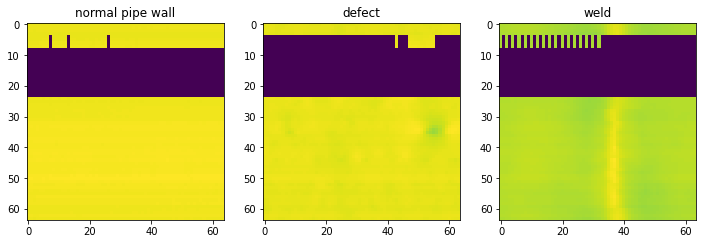

In [180]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(normal_pictures[5], cmap='viridis')
plt.title('normal pipe wall')
plt.subplot(1,3,2)
plt.imshow(pictures_with_defects[55], cmap='viridis')
plt.title('defect')
plt.subplot(1,3,3)
plt.imshow(pictures_with_normal_welds[5], cmap='viridis')
plt.title('weld')
plt.show()

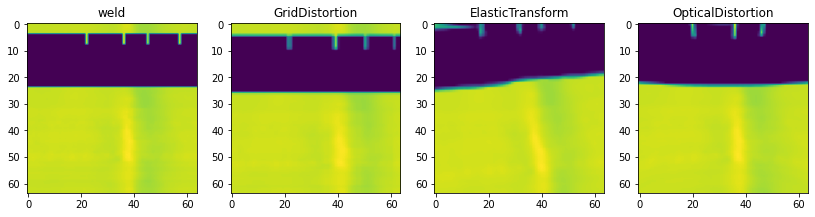

In [179]:
plt.figure(figsize=(14,8))
plt.subplot(1,4,1)
plt.imshow(pictures_with_normal_welds[4], cmap='viridis')
plt.title('weld')
plt.subplot(1,4,2)
plt.imshow(GridDistortion(p=1.0)(image=pictures_with_normal_welds[4])['image'], cmap='viridis')
plt.title('GridDistortion')
plt.subplot(1,4,3)
plt.imshow(ElasticTransform(p=1.0, alpha=20, sigma=120 * 0.05, alpha_affine=120 * 0.05)(image=pictures_with_normal_welds[4])['image'], cmap='viridis')
plt.title('ElasticTransform')
plt.subplot(1,4,4)
plt.imshow(OpticalDistortion(p=1, distort_limit=1, shift_limit=0.3)(image=pictures_with_normal_welds[4])['image'], cmap='viridis')
plt.title('OpticalDistortion')
plt.show()


In [0]:
# train dataset preparation
# pictures preparation
X_train_normal = [x for i, x in enumerate(normal_pictures, start=1) if i % 20 != 0]
X_train_welds = [x for i, x in enumerate(pictures_with_normal_welds, start=1) if i % 5 != 0]
X_train_defects = [x for i, x in enumerate(pictures_with_defects, start=1) if i % 5 != 0]

# labels preparation
y_train_normal = [np.array([0])]*len(X_train_normal)
y_train_welds = [np.array([1])]*len(X_train_welds)
y_train_defects = [np.array([2])]*len(X_train_defects)
# augmentation applying
X_train_welds, y_train_welds = augmentation(X_train_welds, y_train_welds, augmentations_welds)
X_train_defects, y_train_defects = augmentation(X_train_defects, y_train_defects, augmentations_defects)

# final vars
X_train = X_train_normal + X_train_welds + X_train_defects
y_train = y_train_normal + y_train_welds + y_train_defects

In [185]:
print(f'normal train length = {len(y_train_normal)}')
print(f'welds train length = {len(y_train_welds)}')
print(f'defects train length = {len(y_train_defects)}')

normal train length = 11106
welds train length = 11300
defects train length = 8535


In [0]:
# test dataset preparation
# pictures preparation
X_test_normal = [x for i, x in enumerate(normal_pictures, start=1) if i % 20 == 0]
X_test_welds = [x for i, x in enumerate(pictures_with_normal_welds, start=1) if i % 5 == 0]
X_test_defects = [x for i, x in enumerate(pictures_with_defects, start=1) if i % 5 == 0]

# labels preparation
y_test_normal = [np.array([0])]*len(X_test_normal)
y_test_welds = [np.array([1])]*len(X_test_welds)
y_test_defects = [np.array([2])]*len(X_test_defects)

# final vars
X_test = X_test_normal + X_test_welds + X_test_defects
y_test = y_test_normal + y_test_welds + y_test_defects

In [156]:
print(f'normal test length = {len(y_test_normal)}')
print(f'welds test length = {len(y_test_welds)}')
print(f'defects test length = {len(y_test_defects)}')

normal test length = 584
welds test length = 282
defects test length = 142


In [157]:
print(f'train length = {len(y_train)}')
print(f'test length = {len(y_test)}')

train length = 30941
test length = 1008


In [0]:
batch_size = 64

tensor_X = torch.Tensor(X_train)[:, None]
tensor_y = torch.Tensor(y_train)

my_dataset = TensorDataset(tensor_X, tensor_y)
train_loader = DataLoader(my_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2)

tensor_X = torch.Tensor(X_test)[:, None]
tensor_y = torch.Tensor(y_test)

my_dataset = TensorDataset(tensor_X, tensor_y)
test_loader = DataLoader(my_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=2)

In [0]:
# Convolutional neural network (two convolutional layers)
class CNN5(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))

        self.fc = nn.Linear(2048, num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# Convolutional neural network (two convolutional layers)
class CNN7(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.33))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.5))
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.5))
        self.layer7 = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.5))

        self.fc = nn.Linear(2048, num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# Convolutional neural network (two convolutional layers)
class CNN2(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7),
            nn.ReLU(),
            nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.LocalResponseNorm(16),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(4608, num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# model = CNN2().to(device)
model = CNN2().to(device)

learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       verbose=True, 
                                                       threshold=0.0001, 
                                                       factor=0.5, 
                                                       min_lr=0.0001,
                                                       patience=len(train_loader))

In [163]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

experiment_name = "{}@{}".format('detection', datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

experiment_name: detection@05.06.2020-10:16:44


In [164]:
num_epochs = 12

# Train the model
total_step = len(train_loader)
for epoch in trange(num_epochs):
    model.train()
    correct = 0
    total = 0
    i = 0
    for (images, labels) in tqdm(train_loader):
        images = images.to(device)
        labels = labels.long()[:,0].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step(loss)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error = 100 * correct / total

        writer.add_scalar('train/loss', loss.item(), epoch * total_step + i + 1)
        writer.add_scalar('train/accuracy', error, epoch * total_step + i + 1)   
        i += 1 
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.3f}, Accuracy: {error:.2f}')
    
    model.eval()
    correct_test = 0
    total_test = 0
    for (images_test, labels_test) in test_loader:
        #test
        images_test = images_test.to(device)
        labels_test = labels_test.long()[:,0].to(device)

        outputs_test = model(images_test)
        loss_test = criterion(outputs_test, labels_test)

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()
        error_test = 100 * correct_test / total_test

    writer.add_scalar('test/loss', loss_test.item(), epoch + 1)
    writer.add_scalar('test/accuracy', error_test, epoch + 1)


Epoch [1/12], Loss: 0.813, Accuracy: 51.01



Epoch [2/12], Loss: 0.406, Accuracy: 76.92



Epoch [3/12], Loss: 0.439, Accuracy: 80.61


Epoch  1601: reducing learning rate of group 0 to 5.0000e-04.

Epoch [4/12], Loss: 0.494, Accuracy: 82.96



Epoch [5/12], Loss: 0.329, Accuracy: 86.07



Epoch [6/12], Loss: 0.408, Accuracy: 88.82



Epoch [7/12], Loss: 0.243, Accuracy: 89.79


Epoch  3587: reducing learning rate of group 0 to 2.5000e-04.

Epoch [8/12], Loss: 0.254, Accuracy: 90.62



Epoch [9/12], Loss: 0.393, Accuracy: 91.08


Epoch  4737: reducing learning rate of group 0 to 1.2500e-04.

Epoch [10/12], Loss: 0.175, Accuracy: 91.40


Epoch  5222: reducing learning rate of group 0 to 1.0000e-04.

Epoch [11/12], Loss: 0.369, Accuracy: 91.73



Epoch [12/12], Loss: 0.313, Accuracy: 91.81



In [0]:
# test_accuracy = []
# train_accuracy = []

In [167]:

# Test the model
model.eval()
with torch.no_grad():
    correct0 = 0
    total0 = 0
    correct1 = 0
    total1 = 0
    correct2 = 0
    total2 = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)[:,0]

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total0 += labels[labels == 0].size(0)
        correct0 += ((predicted == 0) & (labels == 0)).sum().item()
        total1 += labels[labels == 1].size(0)
        correct1 += ((predicted == 1) & (labels == 1)).sum().item()
        total2 += labels[labels == 2].size(0)
        correct2 += ((predicted == 2) & (labels == 2)).sum().item()

    print('Test accuracy on normal pictures: {:.2f} %'.format(100 * correct0 / total0))
    print('Test accuracy on welds: {:.2f} %'.format(100 * correct1 / total1))
    print('Test accuracy on defects: {:.2f} %'.format(100 * correct2 / total2))
# test_accuracy.append((100 * correct0 / total0,100 * correct1 / total1))
print('\n')

with torch.no_grad():
    correct0 = 0
    total0 = 0
    correct1 = 0
    total1 = 0
    correct2 = 0
    total2 = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.long().to(device)[:,0]

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total0 += labels[labels == 0].size(0)
        correct0 += ((predicted == 0) & (labels == 0)).sum().item()
        total1 += labels[labels == 1].size(0)
        correct1 += ((predicted == 1) & (labels == 1)).sum().item()
        total2 += labels[labels == 2].size(0)
        correct2 += ((predicted == 2) & (labels == 2)).sum().item()

    print('Train accuracy on normal pictures: {:.2f} %'.format(100 * correct0 / total0))
    print('Train accuracy on welds: {:.2f} %'.format(100 * correct1 / total1))
    print('Train accuracy on defects: {:.2f} %'.format(100 * correct2 / total2))
# train_accuracy.append((100 * correct0 / total0,100 * correct1 / total1))
# Save the model checkpoint
# torch.save(model.state_dict(), "checkpoint.pth")

Test accuracy on normal pictures: 95.72 %
Test accuracy on welds: 97.52 %
Test accuracy on defects: 48.59 %


Train accuracy on normal pictures: 95.07 %
Train accuracy on welds: 94.96 %
Train accuracy on defects: 83.76 %


Test accuracy on normal pictures: 99.66 %
Test accuracy on welds: 99.65 %
Test accuracy on defects: 81.69 %

In [0]:
%load_ext tensorboard

In [29]:
logs_base_dir = "./tb"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

<IPython.core.display.Javascript object>